In [1]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1- 
Using Sqlite, create a database named "test" and create 3 tables named revenue, spend and installs storing the associated csv files. 

In [2]:
conn=sqlite3.connect("test.db")
#conn=sqlite3.connect(":memory:")
#conn.execute("attach ? as 'schemaname'", (filename,))
cur=conn.cursor()#tells db what u want to do

In [3]:
installs=pd.read_csv("installs.csv")
revenue=pd.read_csv("revenue.csv")
spend=pd.read_csv("spend.csv")

In [4]:

installs.to_sql('installs', conn, if_exists='replace', index = False)
revenue.to_sql('revenue', conn, if_exists='replace', index = False)
spend.to_sql('spend', conn, if_exists='replace', index = False)


In [5]:
[print(row) for row in cur.execute("""SELECT * FROM installs limit 3""")]
print("************************************************")
[print(row) for row in cur.execute("""SELECT * FROM revenue limit 3""")]
print("************************************************")     
[print(row) for row in cur.execute("""SELECT * FROM spend limit 3""")]

('RU', 23, '1ec78a0d-c9c1-4f22-acd5-494d9a06209d', 'fruit_battle', 2021, 12, 2)
('RU', 23, 'e58579ff-5c01-469b-b701-0d96ca5eaca2', 'fruit_battle', 2021, 12, 2)
('RU', 23, 'a2892289-4c37-438a-aff5-aabbee1bad9e', 'fruit_battle', 2021, 12, 2)
************************************************
('BR', 'fruit_battle', 2021, 12, 23, '6ddf67b9-91e8-4379-9ef9-614f6cf6e712', -0.00503)
('RU', 'fruit_battle', 2021, 12, 23, 'cd74651f-8c3c-449f-835a-13ba053e0ae4', -0.00013000000000000002)
('BR', 'fruit_battle', 2021, 12, 23, 'b3d99a55-5a19-40dc-a17f-a0a1f79fe35a', -0.00049)
************************************************
(9, 'fruit_battle', 2021, 12, 15, 4.84100002329797)
(4, 'fruit_battle', 2021, 12, 15, 36.626018833369)
(10, 'fruit_battle', 2021, 12, 11, 30.0139523213729)


[None, None, None]

In [6]:
#conn.close()

# 2- 
Combine datasets using SQL queries to generate a summary table which contains columns for

### Ad Spend, Installs, CPI, ARPI_D1, ARPI_D14, ROAS_D14 

for each client(app), country and install date between 01-12-2021 and 15-12-2021..

* ARPI_D1: Average revenue value a user has made within the first 1 day after the install (day revenue - day install <= 1)
           (rev day+ rev day+1)/user on day
* ARPI_D14: Average revenue value a user has made within the first 14 day after the install (day revenue - day install <= 14) 
            (rev day+ ....rev day+14)/user on day
* ROAS_D14: ROAS after 14 days from the install.  Return On Advertising Spend, (ROAS), 
            revenue+14/spend
* CPI: Cost per install

In [7]:
installs["install_date"]=pd.to_datetime(installs[['year', 'month', 'day']])
revenue["revenue_date"]=pd.to_datetime(revenue[['year', 'month', 'day']])
spend["spend_date"]=pd.to_datetime(spend[['year', 'month', 'day']])


In [8]:
install_date=installs[["install_date","user_install_id","country_id","client"]].groupby(["client","install_date"]).count()#head()
spend_date=spend[["spend_date","spend","country_id","client"]].groupby(["client","spend_date"]).sum()#head(1)
country_code=dict(zip(installs.country,installs.country_id))
revenue["country_id"]=revenue["country"].map(country_code)
revenue_date=revenue[["revenue_date","revenue","country_id","client"]].groupby(["client","revenue_date"]).sum()#head(1)
df=pd.concat([install_date, spend_date,revenue_date], axis=1)
df["revenue_cum"]=df.revenue.cumsum(axis = 0)
df["spend_cum"]=df.spend.cumsum(axis =0 , skipna=True)

df["ROAS_D14"]=(df["revenue_cum"].shift(periods=-13, fill_value=0)-df["spend_cum"])/df["spend_cum"]
df["cost_per_install"]=df["spend"]/df["user_install_id"]

df["ARPI_D1"]=df.revenue.rolling(window=2, min_periods=1, center=True).sum().astype(int)/df.user_install_id
df["ARPI_D14"]=df.revenue.rolling(window=14, min_periods=1, center=True).sum().astype(int)/df.user_install_id

df=df.drop(["country_id","revenue_cum","spend_cum"],axis=1)

dff=df[["spend", "user_install_id", "cost_per_install", "ARPI_D1", "ARPI_D14", "ROAS_D14"]]
dff.columns=["Spend", "Installs", "CPI", "ARPI_D1", "ARPI_D14", "ROAS_D14"]
#df["spend"]
dff=dff[0:17]
dff.to_sql('summary', conn, if_exists='replace', index = False)
dff

Spend  Installs       CPI   ARPI_D1  ARPI_D14  \
fruit_battle 2021-11-30  1220.207045    5295.0  0.230445  0.114636  1.038338   
             2021-12-01  1112.768256    4903.0  0.226957  0.261065  1.291454   
             2021-12-02   782.701821    4293.0  0.182320  0.297228  1.685535   
             2021-12-03   781.987314    4794.0  0.163118  0.251773  1.677096   
             2021-12-04  2043.075308    9628.0  0.212201  0.184981  0.907873   
             2021-12-05  1786.549364    9896.0  0.180532  0.227162  0.953820   
             2021-12-06  1061.194628    6638.0  0.159867  0.275987  1.502862   
             2021-12-07  1413.917789    7896.0  0.179068  0.202001  1.322062   
             2021-12-08  1166.854922    6183.0  0.188720  0.280932  1.650332   
             2021-12-09  1098.963891    4799.0  0.228999  0.355699  2.059179   
             2021-12-10   606.997091    3538.0  0.171565  0.425382  2.701526   
             2021-12-11   519.890502    3650.0  0.142436  0.383288  2.501370   
             2021-12-12   387.554716    2934.0  0.132091  0.420927  2.766871   
             2021-12-13   375.383147    2206.0  0.170165  0.452856  3.246600   
             2021-12-14   227.540500    1685.0  0.135039  0.494955  3.846884   
             2021-12-15   261.017665    1907.0  0.136873  0.379654  2.988988   
             2021-12-16   263.529137    1507.0  0.174870  0.418713  3.210352   

                         ROAS_D14  
fruit_battle 2021-11-30  7.555155  
             2021-12-01  3.634113  
             2021-12-02  2.582936  
             2021-12-03  1.935713  
             2021-12-04  0.955630  
             2021-12-05  0.525079  
             2021-12-06  0.353875  
             2021-12-07  0.174378  
             2021-12-08  0.058339  
             2021-12-09 -0.031549  
             2021-12-10 -0.073473  
             2021-12-11 -0.106808  
             2021-12-12 -0.130612  
             2021-12-13 -0.152442  
             2021-12-14 -0.165087  
             2021-12-15 -0.179242  
             2021-12-16 -0.193339

In [9]:
[print(row) for row in cur.execute("""SELECT * FROM summary limit 3""")]

(1220.2070447588344, 5295.0, 0.23044514537466182, 0.11463644948064211, 1.0383380547686496, 7.55515538925817)
(1112.76825645368, 4903.0, 0.22695660951533345, 0.26106465429328984, 1.2914542117071182, 3.6341134007855804)
(782.7018206811041, 4293.0, 0.18232048000957468, 0.2972280456557186, 1.6855345911949686, 2.582935716205456)


[None, None, None]

In [10]:
conn.close()

# 3- 
Do an analysis with few bullet points for the current state and the developments observed in Fruit Battle on the top three countries, which have the highest average ARPI_D14 between 01-12-2021 and 15-12-2021, using the metrics you have derived in the second question. Please also define recommendations for the next steps in few bullet points for those countries you have picked. You may use visualisations to support your reasoning.

 (rev day+ ....rev day+14)/user on day

In [11]:
install_date=installs[["user_install_id","country_id","install_date"]].groupby(["country_id","install_date"]).count()#head()
spend_date=spend[["spend","country_id","spend_date"]].groupby(["country_id","spend_date"]).sum()#head(1)
country_code=dict(zip(installs.country,installs.country_id))
revenue["country_id"]=revenue["country"].map(country_code)
revenue_date=revenue[["revenue","country_id","revenue_date"]].groupby(["country_id","revenue_date"]).sum()#head(1)
df_country=pd.concat([install_date, spend_date,revenue_date], axis=1)

df_country_full=df_country.reset_index()
country=df_country_full.level_0.unique()
group_con=df_country_full.groupby("level_0").sum()


AR_D14=[]

for i in country :

    y=df_country_full[df_country_full.level_0==i]
    rev14=y.revenue.rolling(window=14, min_periods=1, center=True).sum().astype(int)#.sum()
    if i==29:
        rev_us=y
        rev_us["AR_D14"]=rev14/rev_us["user_install_id"]
    rev=rev14.sum()
    users=y.user_install_id.sum()
    AR_D14.append(rev/users)
    
group_con["ARP_D14"]=AR_D14
group_con_sort=group_con.sort_values("ARP_D14", ascending=False).reset_index()
country_name = dict([(value, key) for key, value in country_code.items()])
group_con_sort["country_name"]=group_con_sort["level_0"].map(country_name)
group_con_sort.drop("level_0",axis=1)

C:\Program Files\Python36\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,user_install_id,spend,revenue,ARP_D14,country_name
0,19902.0,9474.833408,8016.395981,5.163049,US
1,3528.0,946.424099,710.760019,2.491497,GB
2,6661.0,1578.132840,996.126781,1.885753,DE
3,5642.0,805.693013,599.868540,1.336406,FR
4,22348.0,1128.674001,909.674534,0.526087,RU
5,23671.0,1176.375737,957.502655,0.520046,BR


<AxesSubplot:xlabel='country_name', ylabel='ARP_D14'>

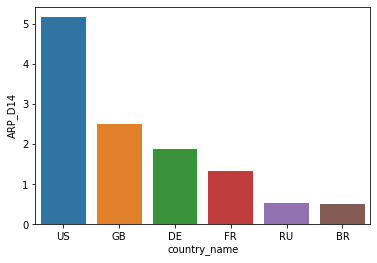

In [12]:
#group_con_sort[["ARP_D14","country_id"]].plot(kind="bar")
sns.barplot(x='country_name', y='ARP_D14',data=group_con_sort )

### US,GB,DE have the most ARPI_D14 between 01-12-2021 and 15-12-2021

# 4- 
The LTV of users are accounted by the revenue they generate over their lifetime afther they have installed. The data you are given has the revenue events for each user up until the first 14 days after each user has installed the app. However, users continue to generate revenue until their lifetime is reached. In the dataset, the revenue events from the 14th day until the lifetime after the install for each user are removed on purpose. Form a regression using ARPI values to estimate the average lifetime value (LTV) for US. In this step, please document how you approach the task. 

Hint: Assume the lifetime of the user is reached at 28 days. Please use the aggregated ARPI values on country level during the estimation process. You can estimate the LTV for every cohort day (install date) or come up with an overall estimate for the UA activity between 01-12-2021 and 15-12-2021.

In [13]:
from neuralprophet import NeuralProphet

In [14]:
rev_us
# prepare expected column names
rev_us.columns = ['Country_code', 'ds','user_install_id','spend','revenue','y']

In [15]:
rev_us_in=rev_us[['ds','y']]

In [16]:
m = NeuralProphet()
metrics = m.fit(rev_us_in)
forecast = m.predict(rev_us_in)
forecast

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.774% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.forecaster.__handle_missing_data) - dropped 14 NAN row in 'y'
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 1000


  0%|          | 0/101 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.72E-01, min: 3.63E+00


  0%|          | 0/101 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.88E+01, min: 2.40E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.02E+00
Epoch[1000/1000]: 100%|█████| 1000/1000 [00:17<00:00, 56.59it/s, SmoothL1Loss=0.00232, MAE=0.56, RMSE=0.659, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.774% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.774% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


,ds,y,yhat1,residual1,trend,season_weekly
0,2021-11-30,2.131497,1.909986,-0.221511,2.083503,-0.173518
1,2021-12-01,2.759777,2.689477,-0.070299,3.263174,-0.573697
2,2021-12-02,4.611789,4.440275,-0.171513,4.097439,0.342836
3,2021-12-03,6.199271,5.439603,-0.759668,4.223513,1.216091
4,2021-12-04,2.213465,3.254698,1.041232,3.564525,-0.309827
5,2021-12-05,2.797328,4.042397,1.245069,4.325305,-0.282908
6,2021-12-06,5.141374,3.945707,-1.195666,4.164684,-0.218977
7,2021-12-07,3.607124,3.845386,0.238262,4.018904,-0.173518
8,2021-12-08,4.187894,3.693205,-0.494689,4.266902,-0.573697
9,2021-12-09,4.517845,5.055935,0.538090,4.713099,0.342836


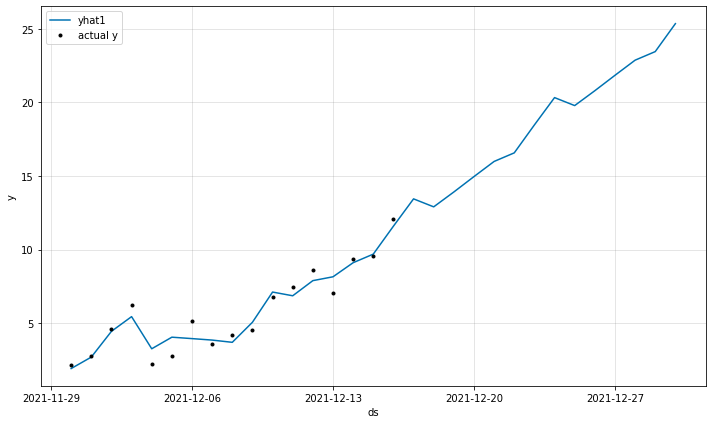

In [17]:
fig_forecast = m.plot(forecast)
#fig_components = m.plot_components(forecast)
#fig_model = m.plot_parameters()


# Some other insights from the data

<AxesSubplot:title={'center':'revenue'}, xlabel='country_name', ylabel='revenue'>

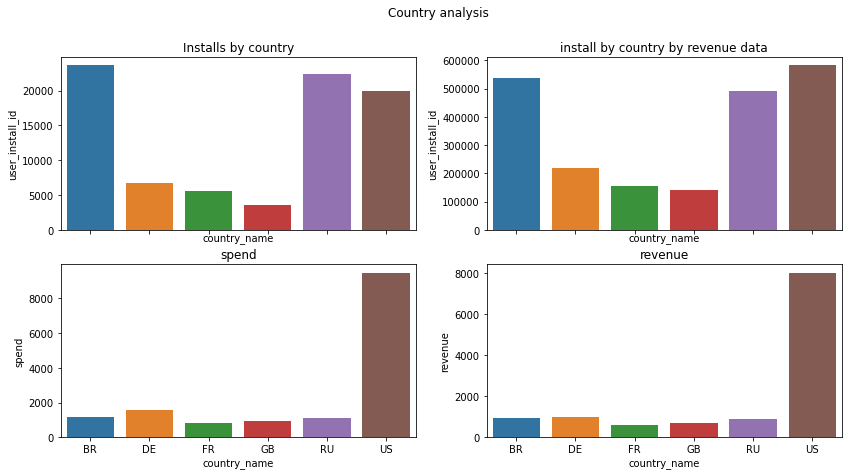

In [20]:
figure, axes = plt.subplots(2, 2, sharex=True, figsize=(14,7))
figure.suptitle('Country analysis')
axes[0,0].set_title('Installs by country')
axes[0,1].set_title('install by country by revenue data')
axes[1,0].set_title('spend')
axes[1,1].set_title('revenue')

installs["country_name"]=installs["country_id"].map(country_name)
spend["country_name"]=spend["country_id"].map(country_name)
revenue["country_name"]=revenue["country_id"].map(country_name)
sns.barplot(ax=axes[0, 0],x='country_name', y='user_install_id',data=installs.groupby("country_name").count().reset_index() )
sns.barplot(ax=axes[0, 1],x='country_name', y='user_install_id',data=revenue.groupby("country_name").count().reset_index() )
sns.barplot(ax=axes[1, 0],x='country_name', y='spend',data=spend.groupby("country_name").sum().reset_index() )
sns.barplot(ax=axes[1, 1],x='country_name', y='revenue',data=revenue.groupby("country_name").sum().reset_index() )

### Most expenditure  and revenue is done on US region.
### Most Installation is high in  BR and RU also.

(<AxesSubplot:title={'center':'Spend'}, xlabel='spend_date'>,
 <AxesSubplot:title={'center':'Revenue'}, xlabel='revenue_date'>,
 <AxesSubplot:title={'center':'installs'}, xlabel='install_date'>)

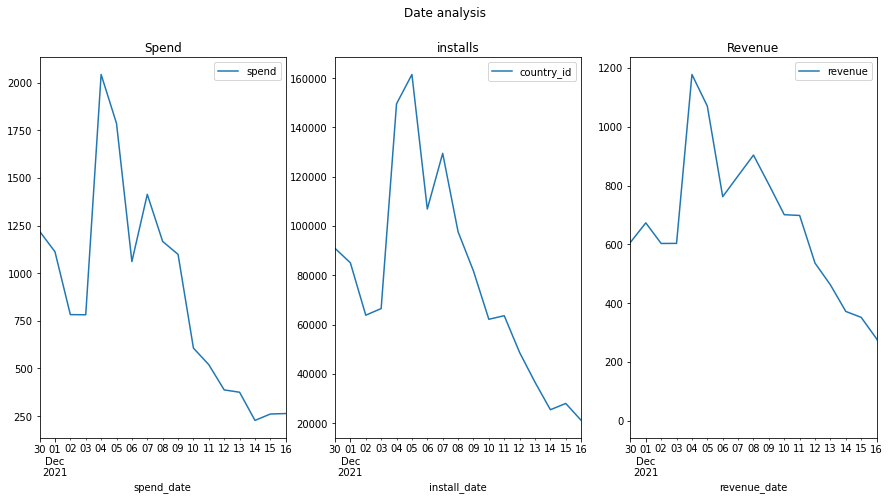

In [19]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15,7))
figure.suptitle('Date analysis')
axes[0].set_title('Spend')
axes[1].set_title('installs')
axes[2].set_title('Revenue')
installs_df=installs.copy()
revenue_df=revenue.copy()
spend_df=spend.copy()
installs_df=installs_df.drop(['client','year', 'month', 'day'], axis = 1)
revenue_df=revenue_df.drop(['client','year', 'month', 'day','country_id','country'], axis = 1)
spend_df=spend_df.drop(['client','year', 'month', 'day','country_id'], axis = 1)

spend_df.groupby("spend_date").sum().plot(ax=axes[0]),revenue_df.groupby("revenue_date").sum().plot(ax=axes[2]),installs_df.groupby("install_date").sum().plot(ax=axes[1])

### As high amount of money is spent on 3th there is sharp rise in installs and revenue on 4th 